# Predicting Gender in Sinhala Names

When using Sinhala names to predict gender, it is necessary to identify the best number of indicators that should be used and how these indicators are represented. In this particular implementation classifiers are trained with varying number of features/indicators(last letter, last two letters, and last three letters). When representing each of these features/indicators, it is assumed that each sinhala letter can be represented using two unicode characters, vowel or consonant followed by a diacritic. Where the value of the diacritic is set to zero if a diacritic is not present after a word.

> letter = ( vowel or consonant, diacritic )

Unicode representation(decimal) of sinhala characters range as follows, 

> 3457 < Vowels and Consonants < 3527 < Diacritics < 3573

Using this approach, if the last two letters are considered when predicting the gender, the set of features will contain four features and the values of these features will be the decimal value of their respective unicode representation. 

The main drawback of this approach is that some letters will not be well represented. For example if we consider the word 'ප්‍රමෝද්‍යා', the last two characters are represented by \[3503, 3530, 8205, 3514, 3535\]. The first two characters represent 'ද්', the last two characters represent 'යා', and the third character is out of the unicode range. When extracting letters/features, in the implemented approach, out of range unicodes characters are ignored. Therefore the last two characters of 'ප්‍රමෝද්‍යා' will be represented as 'ද්යා' 

## Importing required libraries

In [1]:
import os
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from matplotlib import pyplot as plt

from sklearn import tree                                      # Decision Tree Classifier
from sklearn.svm import SVC                                   # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier           # Random Forest Classifier
from sklearn.linear_model import LogisticRegression           # Logistic Regression model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

## Implementing support functions

The following support functions are used to extract and represent features from sinhala letters. 

The ```is_letter()``` function determines if a given character is a sinhala vowel or a consonant by comparing its unicode value with the range of sinhala unicode values. Similarly the ```in_range()``` function is used to determine if a given unicode character is within the range of sinhala characters(consonent, vowel, ordiacritic)

In [2]:
# Sinhala vowels and consonents start at unicode 3457 (decimal)
vowels_and_consonants_start = 3457
# Sinhala vowels and consonents end at unicode 3527
vowels_and_consonants_end = 3527
# Sinhala characters end at 3573
sinhala_end = 3573

# If the character is a sinhala vowel or a consonant True is returned
def is_letter(letter):
    if vowels_and_consonants_start <= ord(letter) <= vowels_and_consonants_end:
        return True
    
# If the charcter is in the sinhala unicode range True is returned
def in_range(letter):
    if vowels_and_consonants_start <= ord(letter) <= sinhala_end:
        return True

The ```generate_feature()``` function creates a feature representation of a given name. The function takes the **name** and the **number of features** as inputs to the function and characters are extracted from the end of the name depending on the number of features required. As per the design of this method, the length of the feature list is going to be 2 times the number of extracted letters(each letter is represented by 2 unicode characters).

The function returns a feature list, representing the last n characters of the name.

Given a name, the function scan the name in reverse order. As each letter is represented by two unicode characters as \[vowel/consonant, diacritic\], position of the diacritic is divisible by two and the position of the vowel/consonant is not divisible by two.

In [3]:
def generate_feature(name, no_of_features):
    # stores the extracted feature list 
    feature = list()
    
    # Count is used to determine the character type(vowel/consonant or diacritic)
    count = 0
    # Name is scanned in the reverse order
    for character in reversed(name):
        # if the character is a sinhala vowel/consonant and count is divisible by zero,
        # then there is no diacritic present in the letter. Therefore the diacritic is set to zero
        # by appending zero to the feature list first and then the unicode of the given letter is appended
        # count is increased by 2 to point to the dicritic of the next letter.
        if is_letter(character) and count%2 == 0:
            feature.append(0)
            feature.append(ord(character))
            count += 2
        # if the character is a sinhala vowel/consonant and count is not divisible by zero,
        # then the unicode of the character is appended to the feature list directly
        elif is_letter(character) and count%2 != 0:
            feature.append(ord(character))
            count += 1
        # If the character is a diacritic then it is appended to the feature list directly
        elif is_letter(character) == None and in_range(character):
            feature.append(ord(character))
            count += 1
        
        # if the count reaches the number of required features x 2 (each letter is represented by 2 characters)
        # the process is halted
        if count == no_of_features*2:
            break
           
    # the created list is in reverse order so it is revered before returning 
    return list(reversed(feature))

The feature vector extracted from the last 2 letters of the word 'ප්‍රමෝද්‍යා' is represented as follows

In [4]:
print(generate_feature('ප්‍රමෝද්‍යා', 2))

[3503, 3530, 3514, 3535]


## Creating the Dataframe

Initially, ```male.txt``` and ```female.txt``` are read as csv and an extra column is added to represent the relavant label ```male``` or ```female```. 

In [5]:
# reading the files
male = pd.read_csv("data/male.txt", names=['name'], encoding='utf8')
female = pd.read_csv("data/female.txt", names=['name'], encoding='utf8')

# adding label column
male['gender'] = 'male'
female['gender'] = 'female'

print(male.shape)
print(female.shape)

(246, 2)
(211, 2)


The two separate dataframes(male and female) are combined to create a single dataframe and samples are shuffled to randomize them. The created dataframe contains 457 samples with 2 columns.

In [6]:
# combining the dataframes
dfs = [male, female]
dataframe = pd.concat(dfs)

# shuffling the samples
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

print('Shape of the Dataframe: ',dataframe.shape)
dataframe.head()

Shape of the Dataframe:  (457, 2)


,name,gender
0,කෞෂල්‍ය,male
1,දිනේෂ්ෂාන්,male
2,හසිනි,female
3,වසන්ති,female
4,ඉඳුවර,male


## Splitting the Dataframe into train and test sets

The dataframe is split into train and test sets with a 80-20 split.

In [7]:
df = dataframe.copy()
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'gender'], 
                                                    df['gender'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=False)

print(X_train.shape)
print(X_test.shape)

(365, 1)
(92, 1)


## Extracting features

The created ```generate_feature()``` function is used to extract the required number of letters from names in train and test sets. The names are replaced with lists of equal length(2 x number of required letters), representing the unicode values(decimal) of given characters. 

In [8]:
# generate_feature() is called on each element using lambda functions and apply method
X_train['name'] = X_train['name'].apply(lambda x: generate_feature(x, 3))
X_test['name'] = X_test['name'].apply(lambda x: generate_feature(x, 3))

X_train.head()

,name
0,"[3522, 0, 3517, 3530, 3514, 0]"
1,"[3522, 3530, 3522, 3535, 3505, 3530]"
2,"[3524, 0, 3523, 3538, 3505, 3538]"
3,"[3523, 0, 3505, 3530, 3501, 3538]"
4,"[3507, 3540, 3520, 0, 3515, 0]"


The lists containing features of the names are separated into individual elemets represented by columns in the dataframe. As some names only contain limited number of characters, additional elements of those names will be NaN values. These NaN values are replaced by 0.0 

This process is done on both train and test sets.

In [9]:
# Separating train set list to columns
X_train = X_train['name'].apply(pd.Series)
# replacing NaN with 0.0
X_train = X_train.fillna(0.0)

# Separating test set list to columns
X_test = X_test['name'].apply(pd.Series)
# replacing NaN with 0.0
X_test = X_test.fillna(0.0)

X_train.head()

,0,1,2,3,4,5
0,3522.0,0.0,3517.0,3530.0,3514.0,0.0
1,3522.0,3530.0,3522.0,3535.0,3505.0,3530.0
2,3524.0,0.0,3523.0,3538.0,3505.0,3538.0
3,3523.0,0.0,3505.0,3530.0,3501.0,3538.0
4,3507.0,3540.0,3520.0,0.0,3515.0,0.0


## Model training & making predictions

The following classifiers are used for the classification process.

1. Support Vector Machine
2. Decision Tree Classifier
3. Random Forrest Classifier
4. Logistic Regression

Implementation details of each classifier is shown below.

### Support Vector Machine

In [10]:
svc = SVC()
svc.fit(X_train,y_train)
prediction = svc.predict(X_test)
acc = accuracy_score(prediction, y_test)
acc

0.75

### Decision Tree Classifier

In [11]:
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)
prediction = dtc.predict(X_test)

acc = accuracy_score(prediction, y_test)
acc

0.9456521739130435

### Random Forest Classifier

In [12]:
rfc = RandomForestClassifier()
rfc.fit(X_train , y_train)
prediction = rfc.predict(X_test)

acc = accuracy_score(prediction, y_test)
acc

0.9782608695652174

### Logistic Regression

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

acc = accuracy_score(prediction, y_test)
acc

0.7608695652173914

## Finding the best classifier-feature combination

In this section the above code is organized into functions and multiple classifier-feature combinations are tested to derive the best possible combination. The 4 classifiers mentioned above are combines with 3 sets of features(last letter, last 2 letters, last 3 letters) to derive 12 combinations. 

An in-depth description of the functionality provided by these functions are provided in above sections. 

The ```get_dataframe()``` function reads the text files as csv using pandas, adds the label column, shuffles the combined dataframes and returns the created dataframe.

In [14]:
def get_dataframe():
    # reading files
    male = pd.read_csv("male.txt", names=['name'], encoding='utf8')
    female = pd.read_csv("female.txt", names=['name'], encoding='utf8')

    # adding label column
    male['gender'] = 'male'
    female['gender'] = 'female'
    
    # combining the 2 dataframes
    dfs = [male, female]
    dataframe = pd.concat(dfs)
    
    # shuffling samples
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    
    return dataframe

The ```convert_names_to_feature()``` function extracts the required number of features/letters from names using the ```generate_feature()``` support function and separate the features into individual elemets represented by columns in the dataframe. This function also replaces the NaN values by 0.0

In [15]:
def convert_names_to_features(X, no_of_features):
    # extracting name features
    X['name'] = X['name'].apply(lambda x: generate_feature(x, no_of_features))
    
    # splitting the list of features into columns
    X = X['name'].apply(pd.Series)
    # replacing NaN with 0.0
    X = X.fillna(0.0)
    
    return X

Given a name of a classifier this function initializes the respective classifier and returns it. 

In [16]:
def get_classifier(name):
    if name == 'Decision Tree':
        return tree.DecisionTreeClassifier()
    elif name == 'Support Vector':
        return SVC()
    elif name == 'Random Forest':
        return RandomForestClassifier()
    elif name == 'Logistic Regression':
        return LogisticRegression()

The ```name_gender_classifier()``` function performs the following tasks,

1. Extract features from train and test set names using ```convert_names_to_features()```
2. Train the classifier passed as input, using train set.
3. Make predictions on the test set
4. Calculate accuracy, precision, and f1-score and return a tuple

In [17]:
def name_gender_classifier(X_train, X_test, y_train, y_test, no_of_features, classifier):
    # extracting features
    X_train = convert_names_to_features(X_train, no_of_features)
    X_test = convert_names_to_features(X_test, no_of_features)
    
    # Training the classifier
    classifier.fit(X_train, y_train)
    # Making predictions
    pred = classifier.predict(X_test)
    
    # Deriving accuracy based on predictions
    accuracy = accuracy_score(pred, y_test)
    # Deriving precision, recall, f1, support
    precision, recall, f1, support = precision_recall_fscore_support(y_test, pred, average='macro')
    
    return (accuracy, precision, recall, f1)

The classification is performed for each of the classifier-feature combination using the functions that are defined above. For each of the combination, its accuracy, precision, recall, and F1-score are outputted.

In [18]:
# The list of classifiers
classifier_list = ['Decision Tree', 'Support Vector', 'Random Forest', 'Logistic Regression']
# List of features
feature_list = ['Last letter', 'last 2 letters', 'last 3 letters']
features = [1, 2, 3]

# Variable to store details of the best classifer-feature combination
best_accuracy = 0.0
best_classifier = None
best_feature = None

dataframe = get_dataframe()

X_train, X_test, y_train, y_test = train_test_split(dataframe.loc[:, dataframe.columns != 'gender'], 
                                                    dataframe['gender'], 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    shuffle=False)
# Names in test set is saved to identify misclassifications
name_list = X_test['name'].copy()

# Selecting the best classifier-feature combination
for feature in features:
    for clf in classifier_list:
        X = X_train.copy()
        X_t = X_test.copy()
        y = y_train.copy()
        y_t = y_test.copy()
        
        # Get the classifier instance using name
        classifier = get_classifier(clf)
        # Performing classification
        accuracy, precision, recall, f1 = name_gender_classifier(X, X_t, y, y_t, feature, classifier)
        
        # Best combination is selected based on accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_classifier = classifier
            best_feature = feature
            
        print('Feature(s): {}  Classifier: {}'.format(feature_list[features.index(feature)], clf))
        print('-------------------------------------------------')
        print('Accuracy: ', accuracy)
        print('Precision: ', precision)
        print('Recall: ', recall)
        print('F1-Score: ', f1)
        print()
    print('________________________________________________________________________________________________')
    print()

Feature(s): Last letter  Classifier: Decision Tree
-------------------------------------------------
Accuracy:  0.967391304347826
Precision:  0.9625
Recall:  0.9727272727272727
F1-Score:  0.9665007889306955

Feature(s): Last letter  Classifier: Support Vector
-------------------------------------------------
Accuracy:  0.6630434782608695
Precision:  0.7720588235294117
Recall:  0.7181818181818181
F1-Score:  0.6561784207353828

Feature(s): Last letter  Classifier: Random Forest
-------------------------------------------------
Accuracy:  0.967391304347826
Precision:  0.9644249512670565
Recall:  0.9683046683046683
F1-Score:  0.9662385321100917

Feature(s): Last letter  Classifier: Logistic Regression
-------------------------------------------------
Accuracy:  0.6521739130434783
Precision:  0.6862155388471178
Recall:  0.6825552825552825
F1-Score:  0.6520094562647754

________________________________________________________________________________________________

Feature(s): last 2 letter

In [19]:
# The best classifier-feature combination
print('Best Feature: ', best_feature)
print('Best Classifier: ', best_classifier)
print('Best Accuracy: ', best_accuracy)

Best Feature:  2
Best Classifier:  RandomForestClassifier()
Best Accuracy:  0.9782608695652174


As depicted in above results, the highest accuracy(0.97) is obtained when the last 2 letters of a name is considered, combined with the Random Forest Classifier. When considersing other features, Both last letter and last 3 letters manage to obtain accuracies greater than 0.96. And also compared to Logistic Regression and Support Vector Machine classifiers, Decision Tree and Random forest classifiers perform well in this particular classification. 

## Misclassifications of the best classifier

The best classifier identified above is used to make predictions on the test set and misclassified samples are identified. Finally, the misclassified samples are printed with its true label and predicted label of the best classifier.

In [20]:
X_test = convert_names_to_features(X_test, best_feature)

pred = best_classifier.predict(X_test)
# Identifying misclassified samples
misclassified = np.where(pred != y_test)

In [21]:
table = PrettyTable()
table.field_names = ["Misclassified Name", "True Label", "Prediction"]

for sample in misclassified[0]:
    table.add_row((name_list.values[sample], y_test.values[sample], pred[sample]))

print(table)

+--------------------+------------+------------+
| Misclassified Name | True Label | Prediction |
+--------------------+------------+------------+
|        ෆ්‍රෙඩී        |    male    |   female   |
|        විශ්වා        |    male    |   female   |
+--------------------+------------+------------+


## Feature Importance of the best classifier

Feature: 0, Score: 0.07679
Feature: 1, Score: 0.05707
Feature: 2, Score: 0.08253
Feature: 3, Score: 0.78361


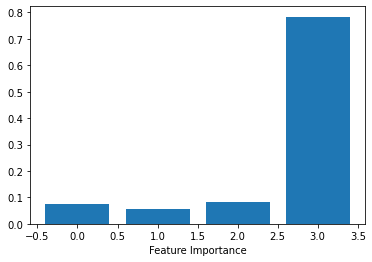

In [22]:
# deriving important features
imp = best_classifier.feature_importances_

# printing the important features with their importance
for f, s in enumerate(imp):
    print('Feature: %0d, Score: %.5f' % (f, s))
    
# plotting the graph    
plt.bar([x for x in range(len(imp))], imp)
plt.xlabel("Feature Importance")
plt.show()

The best classification accuracy is obtained when the last 2 letters are considered. As mentioned in the beginning of this notebook, each letter is represented by two unicode characters. Therefore this particular dataset contains 4 features. The above chart representing the feature importance show that the most impotant feature in this classification is the 4th feature, which is the diacritic of the last letter. 

When looking at the misclassifications of the model, we can see that 2 letters containing 'Diga ispilla(දිග ඉස්පිල්ල)' and 'Ælapilla(	ඇලපිල්ල)' as the final diacritic have been misclassified as female. It is in fact very common for sinhala female names to end with these diacritics. 